In [ ]:
import json
import openml
from scipy.stats import ttest_rel
import lightgbm as lgb
from src import DataBinner
import numpy as np
num_datasets = 18
num_models = 3
num_binning_methods = 3
num_seeds = 20

benchmark_suite = openml.study.get_suite(336) #337 for classification

def sig_func(p_val):
    if p_val < 0.01:
        return '***'
    elif p_val < 0.05:
        return '**'
    elif p_val < 0.1:
        return '*'
    else:
        return ''
    
def get_sig(p_val, val):
    if p_val < 0.05:
        return "\textbf{" +  str(val) + "}"
    else:
        return str(val)
    
    
for idx in range(10):
    if idx == 3:
        continue
    
    task_id = benchmark_suite.tasks[idx]
    task = openml.tasks.get_task(task_id)
    dataset = task.get_dataset()
    name = dataset.name
    print(name)
    name = name.replace("_", "\_")
    obs = dataset.qualities['NumberOfInstances']
    features = dataset.qualities['NumberOfFeatures']
    
    with open(f"../regression_results/regression_results_{idx}.json", "r") as f:
        results = json.load(f)
    
    minibatch_dict = results['minibatch_kmeans']
    linspace_dict = results['linspace']
    quantile_dict = results['quantile']
    
    improvement_kmeans = {}
    improvement_linspace = {}
    
    significance_kmeans = {}
    significance_linspace = {}
    
    for model in ['LGBM', 'CAT', 'XGB']:
        kmeans_results = minibatch_dict[model]
        linspace_results = linspace_dict[model]
        quantile_results = quantile_dict[model]
        
        kmeans_mean = np.mean(kmeans_results)
        #print(f"Kmeans mean: {kmeans_mean}")
        linspace_mean = np.mean(linspace_results)
        quantile_mean = np.mean(quantile_results)
        #print(f"Quantile mean: {quantile_mean}")
        
        improvement_kmeans[model] = 100 * (quantile_mean - kmeans_mean) / quantile_mean
        improvement_linspace[model] = 100 * (quantile_mean - linspace_mean) / quantile_mean
        
        t_stat, p_val = ttest_rel(kmeans_results, quantile_results)
        significance_kmeans[model] = sig_func(p_val)
        
        t_stat, p_val = ttest_rel(linspace_results, quantile_results)
        significance_linspace[model] = sig_func(p_val)
        
        """print(f"KMeans Relative Improvement: {100 * (quantile_mean - kmeans_mean) / quantile_mean:.2f}%")
        print(f"Linspace Relative Improvement: {100 * (quantile_mean - linspace_mean) / quantile_mean:.2f}%")
        
        t_stat, p_val = ttest_rel(kmeans_results, quantile_results)
        print(f"P-value for KMeans vs. Quantile: {p_val:.4f}. SIGNIFICANT? {p_val < 0.05}")
        
        t_stat, p_val = ttest_rel(linspace_results, quantile_results)
        print(f"P-value for Linspace vs. Quantile: {p_val:.4f}")"""

    print(f"{name} & {get_sig(significance_kmeans['LGBM'], improvement_kmeans['LGBM']):.2f} & {get_sig(significance_kmeans['XGB'], improvement_kmeans['XGB']):.2f} & {get_sig(significance_kmeans['CAT'], improvement_kmeans['CAT']):.2f} & {get_sig(significance_linspace['LGBM'], improvement_linspace['LGBM']):.2f} & {get_sig(significance_linspace['XGB'], improvement_linspace['XGB']):.2f} & {get_sig(significance_linspace['CAT'], improvement_linspace['CAT']):.2f} \\\\")
    

cpu_act
Kmeans mean: 5.160197991499957
Quantile mean: 5.434299671649677
Kmeans mean: 5.834513999407086
Quantile mean: 5.901001489514906
Kmeans mean: 5.948329949378968
Quantile mean: 5.343264532089234
cpu\_act & * & ** &  & * & * &  \\
pol
Kmeans mean: 23.009473706685363
Quantile mean: 23.38609436917901
Kmeans mean: 51.63794749254462
Quantile mean: 51.56544011657788
Kmeans mean: 38.082337474823
Quantile mean: 37.744392013549806
pol &  &  &  & ** &  & ** \\
elevators
Kmeans mean: 5.050235182158475e-06
Quantile mean: 5.979158258602819e-06
Kmeans mean: 5.231187388694395e-06
Quantile mean: 6.219270550038396e-06
Kmeans mean: 5.3589566414660185e-06
Quantile mean: 6.263706634967325e-06
elevators & *** & *** & *** & *** & *** & *** \\
Ailerons
Kmeans mean: 2.4791658835144388e-08
Quantile mean: 2.5204335267599148e-08
Kmeans mean: 2.513578908699396e-08
Quantile mean: 2.5569730280846744e-08
Kmeans mean: 2.732176261995188e-08
Quantile mean: 2.7688473520798533e-08
Ailerons & *** & *** & *** &  &  & 

DATASET  Brazilian_houses 8
(10692, 8)
For column 4, the maximum value is 1117000.0 and the median is 560.0. 0.00018705574261129816 are above 1 million


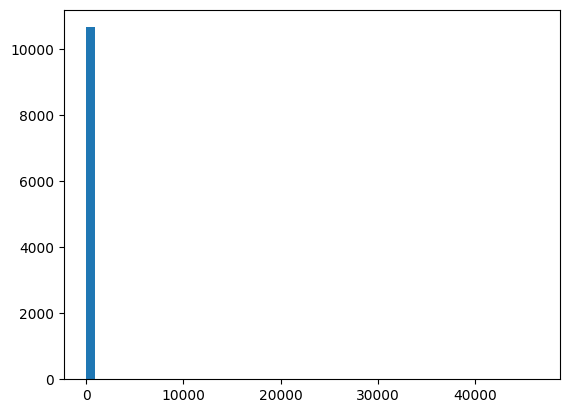

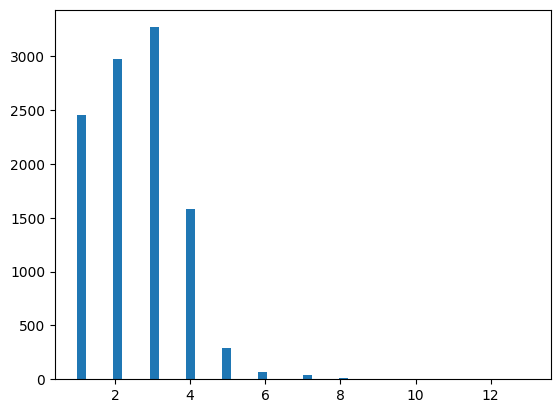

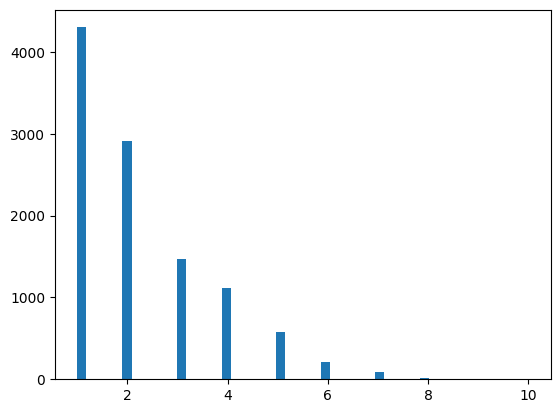

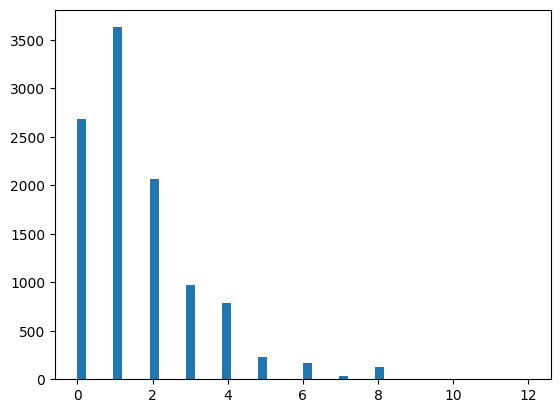

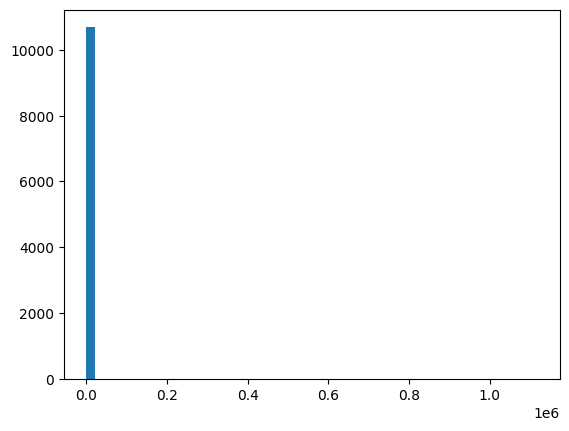

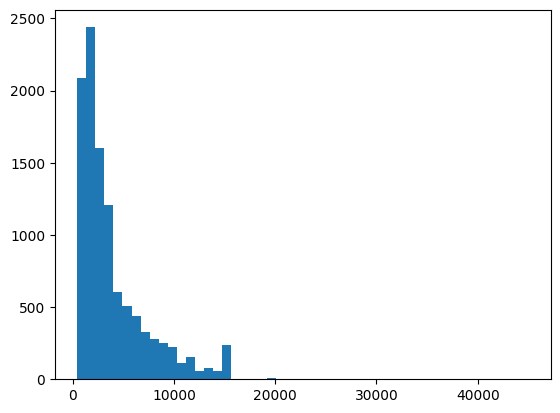

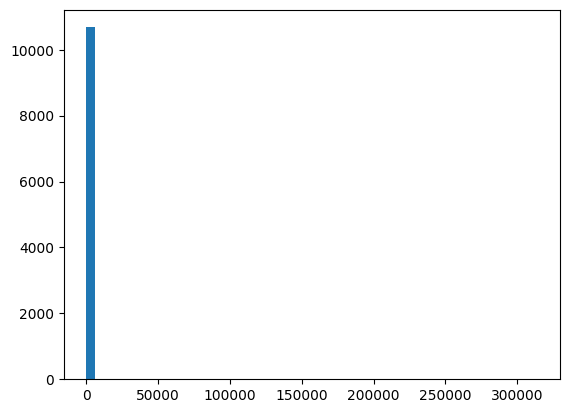

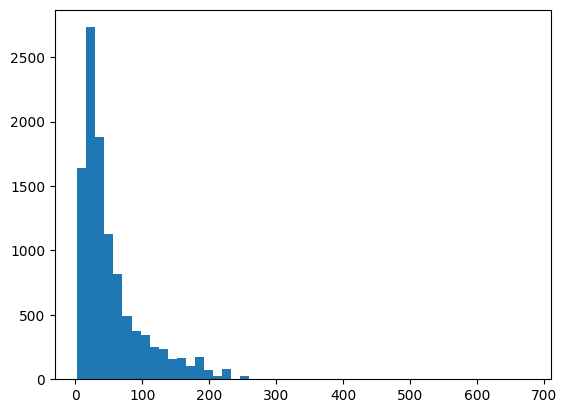

In [34]:
import matplotlib.pyplot as plt
from scipy.stats import skew

mean_skews = []
id = 8    
task_id = benchmark_suite.tasks[id]
task = openml.tasks.get_task(task_id)
print("DATASET ", task.get_dataset().name, id)
X, y = task.get_X_and_y(dataset_format='dataframe')
X = np.array(X)
skews = skew(X, axis = 0)
maxes = np.max(X, axis = 0)
medians = np.median(X, axis = 0)

print(X.shape)
print(f"For column 4, the maximum value is {maxes[4]} and the median is {medians[4]}. {np.mean(X[:, 4] > 1_000_000)} are above 1 million")

for col in range(X.shape[1]):
    plt.hist(X[:, col], bins = 50)
    plt.show()

In [1]:
from scipy.stats import rankdata

print(rankdata([1, 2, 0]))

[2. 3. 1.]
